In [60]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [61]:
if IN_COLAB:
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
  !tar xf spark-3.3.2-bin-hadoop3.tgz
  !mv spark-3.3.2-bin-hadoop3 spark
  !pip install -q findspark
  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark"

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import findspark

In [63]:
findspark.init()
spark_url = 'local'

spark = SparkSession.builder\
        .master(spark_url)\
        .appName('Open Access Prediction with Random Forest')\
        .getOrCreate()

In [64]:
# Load data
file_path = "selected_data_training.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [65]:
# Select relevant columns and cast types
columns_to_select = ["age_of_paper", "reference_count_log", "citation_count_log", "open_access"]
columns_to_cast = ["open_access", "age_of_paper", "reference_count_log", "citation_count_log"]

data = data.select(*columns_to_select)
data = data.select(*(col(c).cast("float").alias(c) if c in columns_to_cast else col(c) for c in data.columns))

# Drop rows with missing values
data = data.dropna()

In [66]:
# Assemble features into a vector
assembler = VectorAssembler(
    inputCols=["age_of_paper", "reference_count_log", "citation_count_log"],
    outputCol="features"
)
data = assembler.transform(data)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)
data = scaler.fit(data).transform(data)

In [67]:
# Split the data into training and testing datasets
train_data, test_data = data.randomSplit([0.75, 0.25], seed=42)

In [68]:
# Define Random Forest Classifier
rf_classifier = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="open_access",
    numTrees=100,
    maxDepth=10,
    seed=42
)

In [69]:
# Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [50, 100]) \
    .addGrid(rf_classifier.maxDepth, [5, 10]) \
    .build()

In [70]:
crossval = CrossValidator(
    estimator=rf_classifier,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="open_access", predictionCol="prediction", metricName="accuracy"),
    numFolds=5
)
# Train the model with cross-validation
cvModel = crossval.fit(train_data)

# Make predictions on the test data
predictions = cvModel.transform(test_data)

In [71]:
# Evaluate the model
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="open_access", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="open_access", predictionCol="prediction", metricName="f1")
evaluator_weightedPrecision = MulticlassClassificationEvaluator(labelCol="open_access", predictionCol="prediction", metricName="weightedPrecision")
evaluator_weightedRecall = MulticlassClassificationEvaluator(labelCol="open_access", predictionCol="prediction", metricName="weightedRecall")

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
weighted_precision = evaluator_weightedPrecision.evaluate(predictions)
weighted_recall = evaluator_weightedRecall.evaluate(predictions)

predictions.groupBy("prediction").count().show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1481|
|       1.0| 3310|
|       2.0|  120|
+----------+-----+

Accuracy: 0.53
F1 Score: 0.51
Weighted Precision: 0.53
Weighted Recall: 0.53


In [72]:
# Analyze feature importances
best_model = cvModel.bestModel
feature_importances = best_model.featureImportances.toArray()

# Feature names
feature_names = ["age_of_paper", "reference_count_log", "citation_count_log"]

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
0,age_of_paper,0.384505
1,reference_count_log,0.328780
2,citation_count_log,0.286715


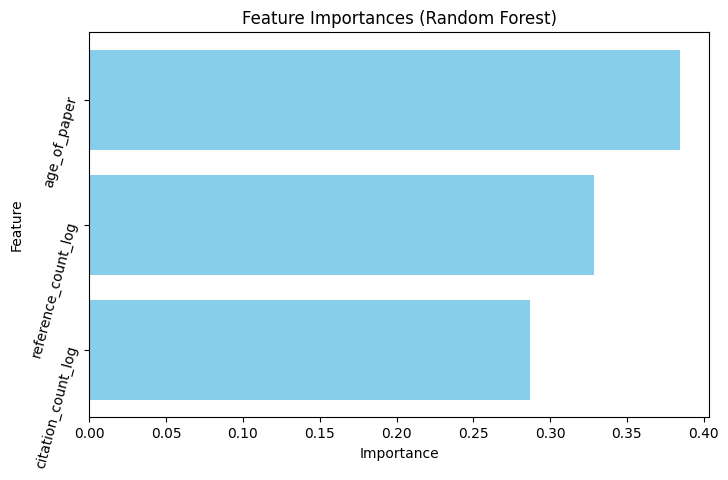

In [73]:
# Plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.yticks(rotation=75)
plt.savefig('feature_importances_plot.png')
# plt.show()

importance_df.to_csv('feature_importances.csv', index=False)

In [74]:
# Stop the Spark session
spark.stop()